In [48]:
import pandas as pd

In [49]:
df=pd.read_csv('PPG_Dataset.csv')

In [50]:
print('Shape of Dataset:',df.shape)

Shape of Dataset: (1199, 2001)


In [51]:
#first 5 rows
df.head()

,0,1,2,3,4,5,6,7,8,9,...,1991,1992,1993,1994,1995,1996,1997,1998,1999,Label
0,-0.015552,0.016963,0.013575,0.027204,0.068154,0.129259,0.127915,0.345174,0.197811,0.167651,...,-0.426464,-0.346976,-0.132168,-0.252098,-0.241969,-0.134235,-0.091327,-0.081713,-0.057693,MI
1,0.002323,0.002754,0.022539,0.228807,0.107751,0.034439,0.086007,0.155667,0.163327,0.223759,...,-0.169345,-0.356808,-0.338996,-0.292489,-0.152872,-0.156076,-0.103265,-0.041579,-0.044272,MI
2,0.050481,-0.339781,0.265111,0.045092,0.040086,0.087173,0.092814,0.099586,-0.143305,0.164186,...,-0.401426,-0.402333,-0.373426,-0.303710,0.008599,-0.180633,-0.143135,-0.084758,0.060668,MI
3,0.023882,0.016561,0.248547,0.054567,0.128032,0.085954,0.107359,0.207137,0.174547,-0.100118,...,-0.390700,-0.353882,-0.294014,-0.267005,-0.242258,-0.186946,-0.173718,0.101331,0.063555,MI
4,-0.058591,0.171551,0.057262,0.270869,0.138357,0.078509,0.062504,0.104447,0.134795,0.194248,...,-0.391598,-0.334490,-0.326873,-0.249881,-0.210052,-0.194763,-0.415365,0.015432,0.010321,MI


In [52]:
#How many values of each category ? 
df.Label.value_counts()

Label
MI        614
Normal    585
Name: count, dtype: int64

In [53]:
# Any missing value ?
df.isnull().sum().sum()

np.int64(0)

In [54]:
import matplotlib.pyplot as plt 

In [55]:
#Split the dataset into MI and Normal People
mi_patients=df[df.Label=='MI']
normal_patients=df[df.Label=='Normal']

In [56]:
mi_signal=mi_patients.iloc[0,:-1] #select all rows and all columns except -1 from mi_patients
normal_signal=normal_patients.iloc[0,:-1] # slect all rows and all columns except last one from normal patients

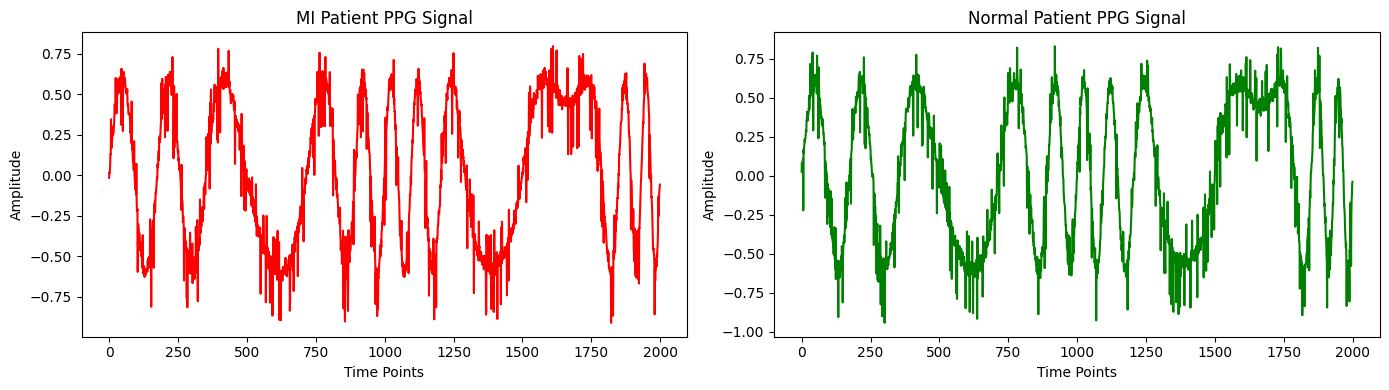

In [57]:
fig,axes=plt.subplots(1,2,figsize=(14,4))
axes[0].plot(mi_signal.values, color='red')
axes[0].set_title('MI Patient PPG Signal')
axes[0].set_xlabel('Time Points')
axes[0].set_ylabel('Amplitude')

axes[1].plot(normal_signal.values, color='green')
axes[1].set_title('Normal Patient PPG Signal')
axes[1].set_xlabel('Time Points')
axes[1].set_ylabel('Amplitude')

plt.tight_layout()
plt.show()

In [58]:
X=df.drop('Label',axis=1)
y=df['Label']

In [59]:
print(f'X Shape: {X.shape}')
print(f'Y Shape: {y.shape}')

X Shape: (1199, 2000)
Y Shape: (1199,)


In [60]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()

In [61]:
y_encoded=le.fit_transform(y)

In [62]:
print("\nOriginal labels:", y[:5].values)
print("Encoded labels: ", y_encoded[:5])
print("\nWhat class is 0?", le.classes_[0])
print("What class is 1?", le.classes_[1])


Original labels: <StringArray>
['MI', 'MI', 'MI', 'MI', 'MI']
Length: 5, dtype: str
Encoded labels:  [0 0 0 0 0]

What class is 0? MI
What class is 1? Normal


In [63]:
# now instead of raw signas we give cleaner signals for more meaningful info we might miss something if selected wrong features, so keep that in mind , also more clue = more accruacy not alwsy sometime 2000 clue but 1990 are irrelvant henc this is termed as signal vs noise problem 

Feature Extraction :
Instead of feeding 2000 raw numbers, we'll extract **meaningful features** from the PPG signal. Think about what describes a heartbeat wave:
```
📊 Statistical features:
   - Mean (average signal level)
   - Standard Deviation (how much it varies)
   - Min and Max values
   - Skewness (is the wave leaning left or right?)

🌊 Signal features:
   - Number of peaks (= heartbeats in the window)
   - Peak height (how strong are the beats?)
   - Distance between peaks (= heart rate rhythm) (This is actually very important since the rmal heart has regular beat but the MI one doesn't)

In [64]:
import numpy as np
from scipy import stats
from scipy.signal import find_peaks

In [65]:
def extract_features(signal):
    '''
    Give one patient PPG signal and extract emaningful features 
    '''
    features={}

    # Statistical Features
    features['mean']=np.mean(signal) # Find average of all samples of a patient , an Mi patient has a lower average amplitude than others
    features['std']=np.std(signal)   # A calm signal has low signal jumping around while a chotic one has very much 
    features['max']=np.max(signal)   
    features['min']=np.min(signal)
    features['range']=np.max(signal)-np.min(signal) # Measure how tall the waves are 
    features['skewness']=stats.skew(signal)  # is the signal biased towards potiive or neagtive value (if skew ~0 then normal )
    features['kurtosis']=stats.kurtosis(signal)  # Are the peaks sharp and apik or flat , the higher the peak more the sharp peaks

    # Peak Features
    peaks, properties = find_peaks(signal, height=0.3, distance=50) # count peaks taller than 0.3 (ignore tiny bumps), two peaks mus be 50 timepoints away from each other (since one heart beat cannot appen instantly) , peaks tell the locations where the peaks were found and properties tell the extra info like heights
    features['num_peaks']=len(peaks) # count number of peaks detected 
    features['mean_peak_height']=np.mean(properties['peak_heights']) \
                                if len(peaks)>0 else 0
    
    # Rhythm Features
    if len(peaks) > 1:
        peak_distances=np.diff(peaks) # disatnce between beats peak_distances = np.diff(peaks) to subtract each numer from the next one or time between each heartbeat. 
        features['mean_peak_distance']=np.mean(peak_distances) #Avg time between heartbeats 
        features['std_peak_distance']=np.std(peak_distances) # if this is low then no problem else problem is present 
    else:
        features['mean_peak_distance']=0
        features['std_peak_distance']=0
    return features

In [66]:
#Apply to all patients
features_list=[]
for i in range(len(X)):
    signal=X.iloc[i].values # get one patients signals
    feats=extract_features(signal)
    features_list.append(feats)

In [67]:
#convert the extract features into a dtaframe and the display it 
X_features=pd.DataFrame(features_list)
X_features.iloc[0]

mean                    0.015579
std                     0.439010
max                     0.795916
min                    -0.910115
range                   1.706031
skewness               -0.089415
kurtosis               -1.427040
num_peaks              16.000000
mean_peak_height        0.671356
mean_peak_distance    126.533333
std_peak_distance      83.999101
Name: 0, dtype: float64

In [68]:
X_features.columns.to_list()

['mean',
 'std',
 'max',
 'min',
 'range',
 'skewness',
 'kurtosis',
 'num_peaks',
 'mean_peak_height',
 'mean_peak_distance',
 'std_peak_distance']

In [69]:
X_features.shape

(1199, 11)

In [70]:
# Add the label back so we can compare
X_features['Label'] = y_encoded

# Calculate average of each feature for MI vs Normal
print("Average features — MI patients (1) vs Normal patients (0):")
print(X_features.groupby('Label').mean().round(3))

Average features — MI patients (1) vs Normal patients (0):
        mean    std    max    min  range  skewness  kurtosis  num_peaks  \
Label                                                                     
0      0.016  0.440  0.829 -0.919  1.747    -0.067    -1.438     15.775   
1      0.004  0.425  0.655 -0.659  1.314    -0.015    -1.490     10.968   

       mean_peak_height  mean_peak_distance  std_peak_distance  
Label                                                           
0                 0.689             130.204             76.758  
1                 0.613             187.488             51.761  


In [71]:
X_features

,mean,std,max,min,range,skewness,kurtosis,num_peaks,mean_peak_height,mean_peak_distance,std_peak_distance,Label
0,0.015579,0.439010,0.795916,-0.910115,1.706031,-0.089415,-1.427040,16,0.671356,126.533333,83.999101,0
1,0.017504,0.437568,0.853141,-0.930693,1.783833,-0.074331,-1.423461,16,0.687637,126.733333,73.266151,0
2,0.014927,0.441476,0.828718,-0.929915,1.758632,-0.076551,-1.397659,16,0.712158,126.466667,82.666290,0
3,0.018500,0.440927,0.892738,-0.946569,1.839307,-0.064739,-1.458610,15,0.733226,136.142857,76.284109,0
4,0.014503,0.440144,0.865031,-0.965543,1.830574,-0.048814,-1.431593,15,0.717895,135.142857,74.916961,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1194,0.002918,0.424983,0.654571,-0.643586,1.298157,-0.014083,-1.491523,11,0.604734,185.300000,53.480931,1
1195,0.015470,0.443162,0.845859,-0.956682,1.802541,-0.069984,-1.418583,16,0.700974,126.733333,79.534870,0
1196,0.003253,0.424523,0.659113,-0.646888,1.306001,-0.012896,-1.493510,11,0.609850,184.500000,53.859540,1
1197,0.003817,0.424296,0.647717,-0.650416,1.298134,-0.010719,-1.491450,11,0.609579,184.600000,54.153855,1


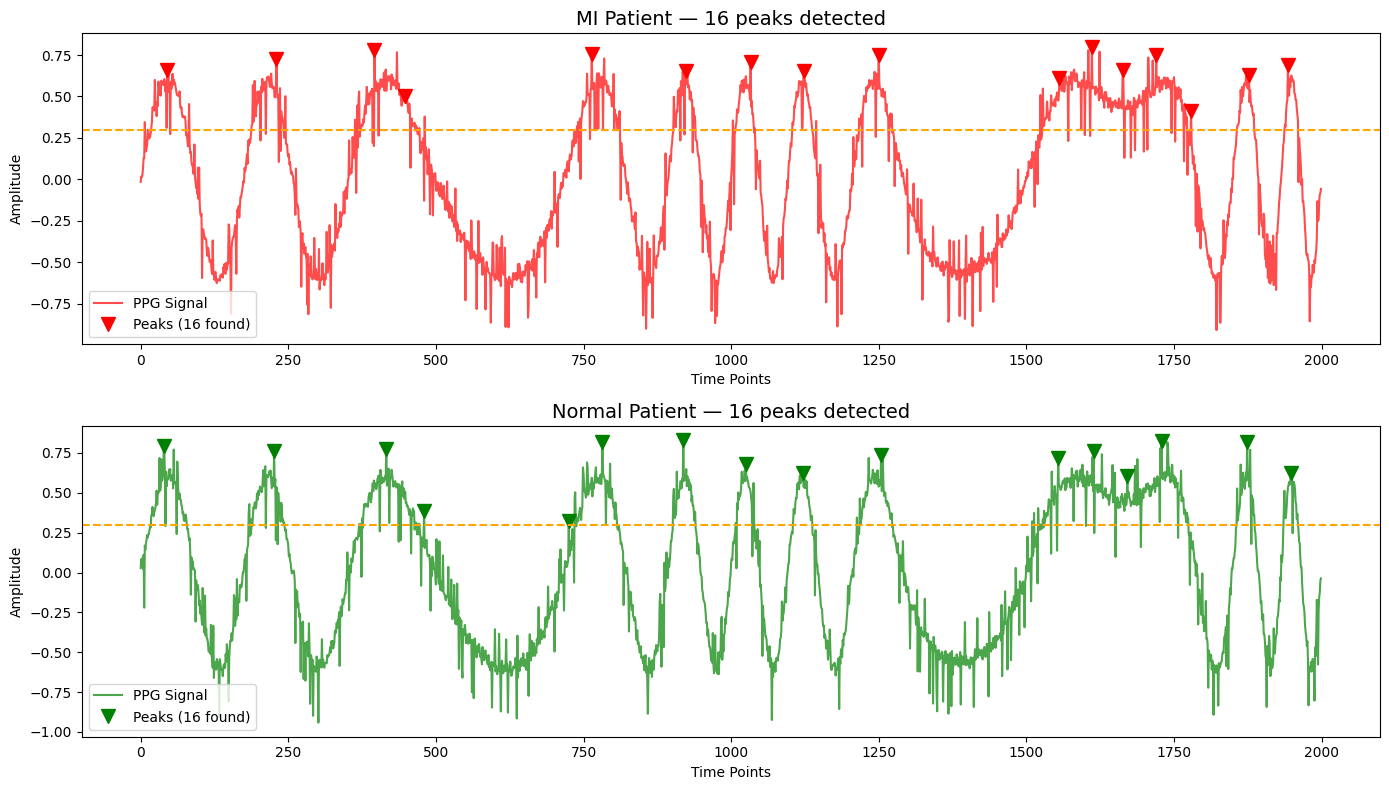


MI Patient:     16 peaks, avg distance between peaks = 126.5 timepoints
Normal Patient: 16 peaks, avg distance between peaks = 127.2 timepoints


In [72]:
# Compare the graph on e one normal and one MI patient
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import numpy as np

# Get one MI and one Normal patient signal
mi_signals     = X[df['Label'] == 'MI'].iloc[0].values
normal_signals = X[df['Label'] == 'Normal'].iloc[0].values

# Find peaks in both
mi_peaks,     mi_props     = find_peaks(mi_signals,     height=0.3, distance=50)
normal_peaks, normal_props = find_peaks(normal_signals, height=0.3, distance=50)

# Plot
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# MI Patient
axes[0].plot(mi_signals, color='red', alpha=0.7, label='PPG Signal')
axes[0].plot(mi_peaks, mi_signals[mi_peaks], 
             'rv', markersize=10, label=f'Peaks ({len(mi_peaks)} found)')
axes[0].set_title(f'MI Patient — {len(mi_peaks)} peaks detected', fontsize=14)
axes[0].set_xlabel('Time Points')
axes[0].set_ylabel('Amplitude')
axes[0].legend()
axes[0].axhline(y=0.3, color='orange', linestyle='--', label='Peak threshold')

# Normal Patient  
axes[1].plot(normal_signals, color='green', alpha=0.7, label='PPG Signal')
axes[1].plot(normal_peaks, normal_signals[normal_peaks],
             'gv', markersize=10, label=f'Peaks ({len(normal_peaks)} found)')
axes[1].set_title(f'Normal Patient — {len(normal_peaks)} peaks detected', fontsize=14)
axes[1].set_xlabel('Time Points')
axes[1].set_ylabel('Amplitude')
axes[1].legend()
axes[1].axhline(y=0.3, color='orange', linestyle='--', label='Peak threshold')

plt.tight_layout()
plt.show()

print(f"\nMI Patient:     {len(mi_peaks)} peaks, "
      f"avg distance between peaks = "
      f"{np.mean(np.diff(mi_peaks)):.1f} timepoints")
print(f"Normal Patient: {len(normal_peaks)} peaks, "
      f"avg distance between peaks = "
      f"{np.mean(np.diff(normal_peaks)):.1f} timepoints") 

In [73]:
from sklearn.model_selection import train_test_split

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X_features,    # our 11 features
    y_encoded,     # MI=1, Normal=0
    test_size=0.2, # 20% for testing
    random_state=42,# so we get same split every time
    stratify=y_encoded  # keep MI/Normal ratio same in both splits
)

print("Training samples:", X_train.shape[0])
print("Testing samples: ", X_test.shape[0])
print("\nMI in training:  ", sum(y_train == 1))
print("Normal in training:", sum(y_train == 0))

Training samples: 959
Testing samples:  240

MI in training:   468
Normal in training: 491


> 🤔 **Question:** What does `stratify=y_encoded` do? Why is it important for a medical dataset specifically? Take a guess before running!

### Part 2 — Train Your FIRST Model!
''' 
We'll start with **Random Forest.** Here's the idea in plain English:
Random Forest = a group of decision trees voting together

One tree might ask:
"Is std_peak_distance > 50?"
   YES → "Is num_peaks < 5?"
              YES → Predict MI
              NO  → Predict Normal
   NO  → Predict Normal

100 trees all vote → majority wins!
Why start with Random Forest and not something fancier?
Simple models first = good engineering practice
If Random Forest works well → no need for complex models
If it fails → then we try harder things
'''

In [74]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Train the model
rf_model = RandomForestClassifier(
    n_estimators=100,  # 100 trees voting together
    random_state=42
)

rf_model.fit(X_train, y_train)  # THIS is where learning happens
print("Model trained!")

# Test it
y_pred = rf_model.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, 
      target_names=['Normal', 'MI']))

Model trained!

Classification Report:
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00       123
          MI       1.00      1.00      1.00       117

    accuracy                           1.00       240
   macro avg       1.00      1.00      1.00       240
weighted avg       1.00      1.00      1.00       240



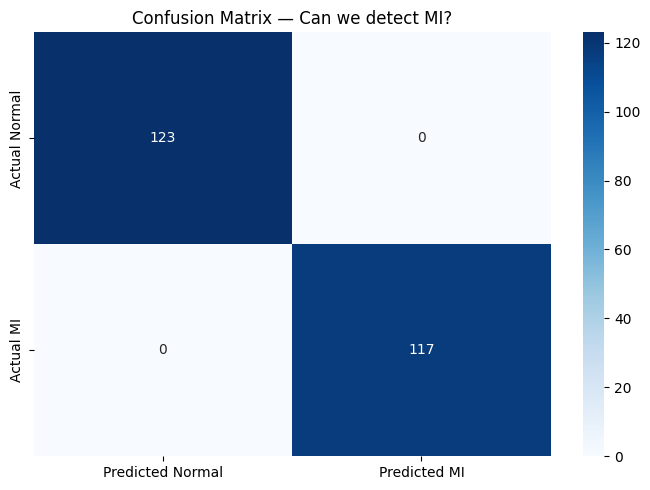

In [75]:
# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Normal', 'Predicted MI'],
            yticklabels=['Actual Normal', 'Actual MI'])
plt.title('Confusion Matrix — Can we detect MI?')
plt.tight_layout()
plt.show()
# '''
# The confusion matrix looks like this:
#                  Predicted Normal  |  Predicted MI
#                  ──────────────────────────────────
# Actual Normal  |   True Negative   |  False Positive
# Actual MI      |   False Negative  |  True Positive
#                                         ↑
#                               We want this HIGH!
#                               (catching real MI cases)
# '''

In [76]:
X_features_clean=X_features.drop('Label',axis=1)
X_features_clean.shape

(1199, 11)

In [78]:
X_features_clean.columns.tolist()

['mean',
 'std',
 'max',
 'min',
 'range',
 'skewness',
 'kurtosis',
 'num_peaks',
 'mean_peak_height',
 'mean_peak_distance',
 'std_peak_distance']

              precision    recall  f1-score   support

      Normal       0.95      0.94      0.95       123
          MI       0.94      0.95      0.94       117

    accuracy                           0.95       240
   macro avg       0.95      0.95      0.95       240
weighted avg       0.95      0.95      0.95       240



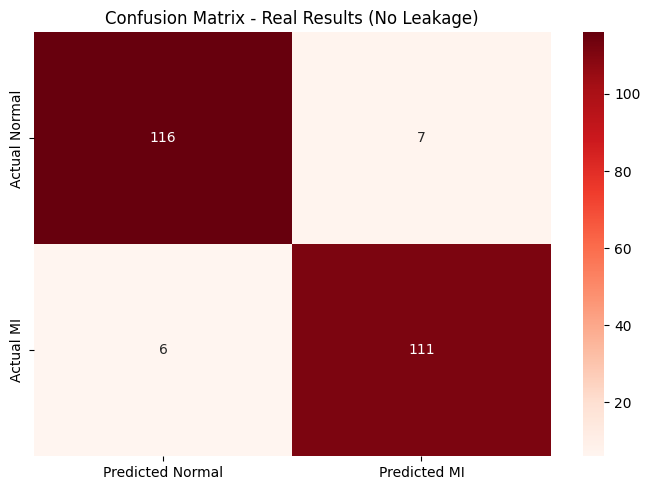

In [79]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1 - Clean split (NO label leakage!)
X_train, X_test, y_train, y_test = train_test_split(
    X_features_clean,  # ← clean features, no label!
    y_encoded,
    test_size=0.2,
    random_state=42,
    stratify=y_encoded
)

# Step 2 - Train
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Step 3 - Evaluate
y_pred = rf_model.predict(X_test)
print(classification_report(y_test, y_pred,
      target_names=['Normal', 'MI']))

# Step 4 - Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds',
            xticklabels=['Predicted Normal','Predicted MI'],
            yticklabels=['Actual Normal','Actual MI'])
plt.title('Confusion Matrix - Real Results (No Leakage)')
plt.tight_layout()
plt.show()
# ```

# ---

# ## About Your `stratify` Answer — Let Me Complete It!

# You said "keeps number of MI and Normal same" — close! More precisely:
# ```
# WITHOUT stratify:
#   Training set might get: 80% Normal, 20% MI  (bad!)
#   Model learns mostly Normal patterns
  
# WITH stratify:
#   Training set gets: 50% Normal, 50% MI  (same as original)
#   Testing set gets:  50% Normal, 50% MI
  
# In medical ML specifically:
#   If training has few MI examples → model never learns MI well
#   → Misses real heart attacks in real world → people die
  
# So stratify = making sure model sees ENOUGH of both classes!

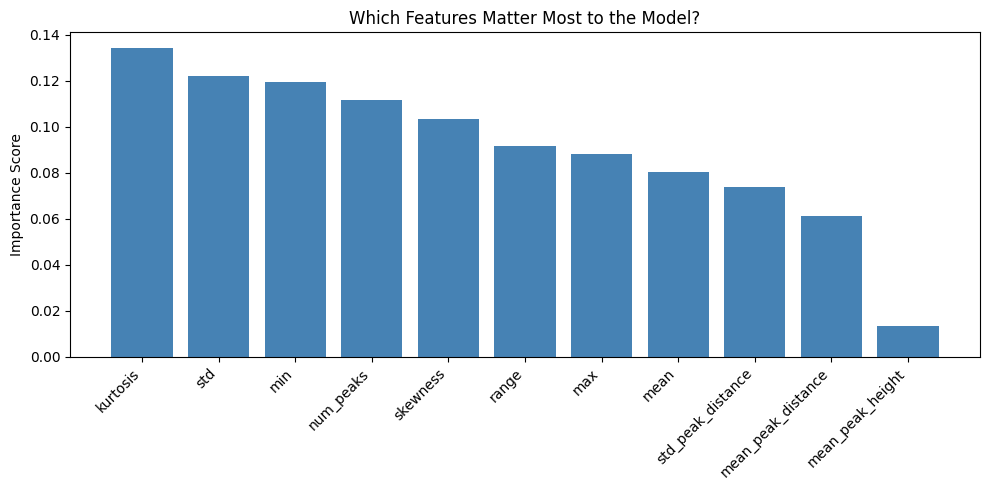


Feature Rankings:
1. kurtosis                  → 0.1344
2. std                       → 0.1223
3. min                       → 0.1195
4. num_peaks                 → 0.1117
5. skewness                  → 0.1032
6. range                     → 0.0918
7. max                       → 0.0883
8. mean                      → 0.0804
9. std_peak_distance         → 0.0738
10. mean_peak_distance        → 0.0612
11. mean_peak_height          → 0.0135


In [80]:
# Which features helped the model most?
importances = rf_model.feature_importances_
feat_names  = X_features_clean.columns.tolist()

# Sort by importance
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 5))
plt.bar(range(len(feat_names)),
        importances[indices],
        color='steelblue')
plt.xticks(range(len(feat_names)),
           [feat_names[i] for i in indices],
           rotation=45, ha='right')
plt.title('Which Features Matter Most to the Model?')
plt.ylabel('Importance Score')
plt.tight_layout()
plt.show()

print("\nFeature Rankings:")
for i, idx in enumerate(indices):
    print(f"{i+1}. {feat_names[idx]:25s} → {importances[idx]:.4f}")

In [81]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import recall_score, accuracy_score

# All models we want to compare
models = {
    'Random Forest'      : RandomForestClassifier(n_estimators=100, 
                                                   random_state=42),
    'Gradient Boosting'  : GradientBoostingClassifier(random_state=42),
    'SVM'                : SVC(random_state=42),
    'KNN'                : KNeighborsClassifier(n_neighbors=5)
}

print(f"{'Model':<22} {'Accuracy':>10} {'MI Recall':>12} {'False Negatives':>17}")
print("-" * 65)

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred     = model.predict(X_test)
    acc        = accuracy_score(y_test, y_pred)
    mi_recall  = recall_score(y_test, y_pred)
    false_negs = sum((y_test == 1) & (y_pred == 0))
    
    results[name] = {'accuracy': acc, 'recall': mi_recall, 
                     'false_negatives': false_negs}
    print(f"{name:<22} {acc:>10.1%} {mi_recall:>12.1%} {false_negs:>17}")

Model                    Accuracy    MI Recall   False Negatives
-----------------------------------------------------------------
Random Forest               94.6%        94.9%                 6
Gradient Boosting           94.2%        94.0%                 7
SVM                         94.6%        94.9%                 6
KNN                         94.6%        94.9%                 6


In [84]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import recall_score, accuracy_score

# All models we want to compare
models = {
    'Random Forest'      : RandomForestClassifier(n_estimators=100, 
                                                   random_state=42),
    'Gradient Boosting'  : GradientBoostingClassifier(random_state=42),
    'SVM'                : SVC(random_state=42),
    'KNN'                : KNeighborsClassifier(n_neighbors=5)
}

print(f"{'Model':<22} {'Accuracy':>10} {'MI Recall':>12} {'False Negatives':>17}")
print("-" * 65)

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred     = model.predict(X_test)
    acc        = accuracy_score(y_test, y_pred)
    mi_recall  = recall_score(y_test, y_pred)
    false_negs = sum((y_test == 1) & (y_pred == 0))
    
    results[name] = {'accuracy': acc, 'recall': mi_recall, 
                     'false_negatives': false_negs}
    print(f"{name:<22} {acc:>10.1%} {mi_recall:>12.1%} {false_negs:>17}")

Model                    Accuracy    MI Recall   False Negatives
-----------------------------------------------------------------
Random Forest               94.6%        94.9%                 6
Gradient Boosting           94.2%        94.0%                 7
SVM                         94.6%        94.9%                 6
KNN                         94.6%        94.9%                 6
